# Monk Notebook

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.network import NeuralNetwork
from src.trainer import Trainer
from src.losses import Loss
from src.utils import DataLoader
from src.utils import onehot_monk
from src.activations import sigmoid

## Monk 1

In [2]:
PATH_TRAIN = 'data/monk/monks-1.train'
PATH_TEST = 'data/monk/monks-1.test'

df_train = pd.read_csv(PATH_TRAIN, sep='\s+', header=None) #sep='\s+' == delim white space
df_test = pd.read_csv(PATH_TEST, sep='\s+', header=None)
df_train.head()

,0,1,2,3,4,5,6,7
0,1,1,1,1,1,3,1,data_5
1,1,1,1,1,1,3,2,data_6
2,1,1,1,1,3,2,1,data_19
3,1,1,1,1,3,3,2,data_22
4,1,1,1,2,1,2,1,data_27


In [3]:
#Convert df in numpy arrays, excluding last column
Train_set = np.array(df_train.iloc[:, :-1], dtype=np.int32)
Test_set = np.array(df_test.iloc[:, :-1], dtype=np.int32)
Train_set.shape, Test_set.shape

((124, 7), (432, 7))

In [4]:
X_train_full = onehot_monk(Train_set[:, 1:]) 
y_train_full = np.reshape(Train_set[:, 0], (len(Train_set), 1))# only first column, need shape (n,1) to work

X_test = onehot_monk(Test_set[:, 1:]) 
y_test = np.reshape(Test_set[:, 0], (len(Test_set), 1))
X_train_full.shape,  X_test.shape, y_train_full.shape, y_test.shape

((124, 17), (432, 17), (124, 1), (432, 1))

In [5]:
INPUT_NEURONS = 17
OUTPUT_NEURONS = 1

HIDDEN_LAYER_SIZES = [8, 16, 32]
HIDDEN_LAYERS_COUNTS = [1, 2, 3]
INTERNAL_ACTIVATIONS = ['tanh', 'leaky relu', 'relu']
OUTPUT_ACTIVATIONS_AND_LOSS = [('sigmoid', 'mse'), ('identity', 'binary cross entropy sigmoid')]
NEURAL_NETWORK_CONFIGURATIONS = []

for hidden_layers_count in HIDDEN_LAYERS_COUNTS:
    for hidden_layer_size in HIDDEN_LAYER_SIZES:
        for internal_activation in INTERNAL_ACTIVATIONS:
            for output_activation, loss_function in OUTPUT_ACTIVATIONS_AND_LOSS:
                architecture = [INPUT_NEURONS] + [hidden_layer_size] * hidden_layers_count + [OUTPUT_NEURONS]
                activations = [internal_activation] * hidden_layers_count + [output_activation]
                NEURAL_NETWORK_CONFIGURATIONS.append((architecture, activations, loss_function))

In [6]:
monk_dataset_1 = DataLoader(X_train_full, y_train_full)
K_FOLDS = monk_dataset_1.k_fold(k = 5)

ETA_CONFIGURATIONS = [0.01, 0.001]
LAMBDA_CONFIGURATIONS = [0, 1e-3, 1e-4]
ALPHA_CONFIGURATIONS = [0, 0.5, 0.9]
EPOCHS = 300

# (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA)
CONFIGURATIONS = []

for NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F in NEURAL_NETWORK_CONFIGURATIONS:
  for ETA in ETA_CONFIGURATIONS:
    for LAMBDA in LAMBDA_CONFIGURATIONS:
      for ALPHA in ALPHA_CONFIGURATIONS:
        config = (NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA)
        CONFIGURATIONS.append(config)

CONFIG_DICTIONARY = {}
LEN_CONFIGURATIONS = len(CONFIGURATIONS)
for i in range(LEN_CONFIGURATIONS):
  CONFIG_DICTIONARY[i] = 0


for i in range(LEN_CONFIGURATIONS):
  print(f"Training {i+1}/{LEN_CONFIGURATIONS}")
  config = CONFIGURATIONS[i]
  for X_train, y_train, X_val, y_val in K_FOLDS:
    NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA = config
    print(f"NEURAL_NETWORK_ARCHITECTURE: {NEURAL_NETWORK_ARCHITECTURE}, NEURAL_NETWORK_ACTIVATION: {NEURAL_NETWORK_ACTIVATION}, LOSS_F: {LOSS_F}, ETA: {ETA}, LAMBDA: {LAMBDA}, ALPHA: {ALPHA}")
    #train
    nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
    trainer = Trainer(
        nn=nn,
        loss=Loss(LOSS_F),
        X_train=X_train,
        y_train=y_train, #no scaling y because of onehot
        X_val=X_val,
        y_val=y_val,
        epochs=EPOCHS,
        early_stopping=100, # no improvements in 50 epochs_> stop
        eta=ETA,               # Learning rate iniziale
        lam=LAMBDA,                # L2
        alpha=ALPHA,               # Momentum
        batch_size=16,
        shuffle_batches=True
    )
    # return_best_nn=True returns the best nn
    best_nn = trainer.train(return_best_nn=True, print_epochs=False, plot_epochs=False)
    #best val accuracy
    out = best_nn.forward(X_val)[-1][-1]
    if LOSS_F == 'binary cross entropy sigmoid':
      out = sigmoid(out)
    
    predictions = np.round(out)
    print(f"Accuracy: {np.mean(predictions == y_val) * 100}%")
    CONFIG_DICTIONARY[i] += np.mean(predictions == y_val)

Training 1/972
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 72.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 76.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 100.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 80.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0
Accuracy: 100.0%
Training 2/972
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['tanh', 'sigmoid'], LOSS_F: mse, ETA: 0.01, LAMBDA: 0, ALPHA: 0.5
Accuracy: 88.0%
NEURAL_NETWORK_ARCHITECTURE: [17, 8, 1], NEURAL_NETWORK_ACTIVATION: ['ta

KeyboardInterrupt: 

In [7]:
CONFIGURATIONS[2]

([17, 8, 1], ['tanh', 'sigmoid'], 'mse', 0.01, 0, 0.9)

In [8]:
TOP_5_CONFIGS_INDEXES = sorted(CONFIG_DICTIONARY, key=CONFIG_DICTIONARY.get, reverse=True)[:5]

for i in TOP_5_CONFIGS_INDEXES:
    ACCURACY = CONFIG_DICTIONARY[i] * 100 / len(K_FOLDS)
    print(f"Config index: {CONFIGURATIONS[i]}, Mean Accuracy: {ACCURACY}%")

Config index: ([17, 8, 1], ['leaky relu', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.001, 0.9), Mean Accuracy: 100.0%
Config index: ([17, 8, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.001, 0.9), Mean Accuracy: 99.2%
Config index: ([17, 8, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.0001, 0), Mean Accuracy: 99.2%
Config index: ([17, 8, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.0001, 0.5), Mean Accuracy: 99.2%
Config index: ([17, 8, 1], ['tanh', 'identity'], 'binary cross entropy sigmoid', 0.01, 0.0001, 0.9), Mean Accuracy: 99.2%


(124, 17) (124, 1) (432, 17) (432, 1)


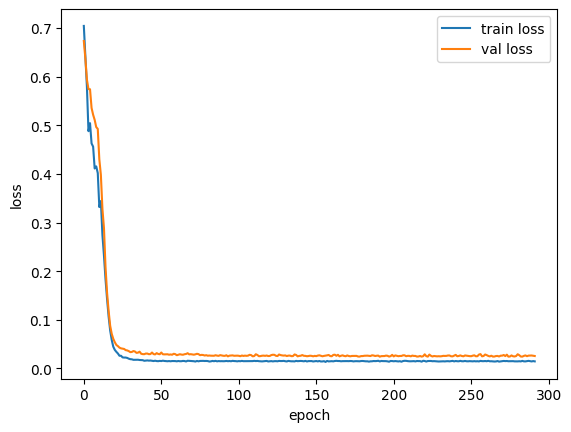

Accuracy: 100.0%


In [9]:
NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, LOSS_F, ETA, LAMBDA, ALPHA = CONFIGURATIONS[TOP_5_CONFIGS_INDEXES[1]]
print(monk_dataset_1.X_train.shape, monk_dataset_1.y_train.shape, X_test.shape, y_test.shape)
nn = NeuralNetwork(NEURAL_NETWORK_ARCHITECTURE, NEURAL_NETWORK_ACTIVATION, std=0.2)
trainer = Trainer(
    nn=nn,
    loss=Loss(LOSS_F),
    X_train=X_train_full,
    y_train=y_train_full, #no scaling y because of onehot
    X_val = X_test,
    y_val=y_test,
    epochs=EPOCHS,
    early_stopping=100, # no improvements in 50 epochs_> stop
    eta=ETA,               # Learning rate iniziale
    lam=LAMBDA,                # L2
    alpha=ALPHA,               # Momentum
    batch_size=16,
    shuffle_batches=True
)
# return_best_nn=True returns the best nn
best_nn = trainer.train(return_best_nn=True, print_epochs=False, plot_epochs=True)
#best val accuracy
out = best_nn.forward(X_val)[-1][-1]
if LOSS_F == 'binary cross entropy sigmoid':
  out = sigmoid(out)

predictions = np.round(out)
print(f"Accuracy: {np.mean(predictions == y_val) * 100}%")
CONFIG_DICTIONARY[i] += np.mean(predictions == y_val)